# Import Data

In [ ]:
import os
import math
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, r2_score

In [ ]:
% pip install imblearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = 'drive/My Drive/20.C51 project/Code/'

In [ ]:
from sklearn import preprocessing
filename = 'df_ortholog.csv'
df = pd.read_csv(os.path.join(base_dir, filename)) 

# filter out gene sequences whose lengths aren't multiples of 3
df = df[df['gene_sequence'].map(len)%3==0]

# filter out gene sequences that contain non ATGC letters
nonATGC = [any(letter not in ['A','T','G','C'] for letter in seq) for seq in df["gene_sequence"]]
datafilter = [not elem for elem in nonATGC]
data = df[datafilter]

# Binarize strand
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1])
data["strand"] = lb.transform(data[["strand"]])

# Create dummy variables for operon position
data = pd.get_dummies(data, columns=['operon_pos'], drop_first=True)

# Recode essentiality
data['essentiality'] = data['essentiality'].astype('category')
encode_map = {
    'E': 1,
    'NE': 0
}
data['essentiality'].replace(encode_map, inplace=True)

# Reset indices
data.index = range(data.shape[0])

# Remove Unnamed columns (first two columns)
data = data.iloc[:,2:]

# Reorder columns
data = data[['geneID', 'SpeciesName', 'locus', 'gene', 
              'Gram','Taxonomy', 'taxaID', 'gene_sequence',
              'protein_sequence','strand','orthogroup',
              'operon_pos_1','operon_pos_2',
              'essentiality',]]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Define which subset of the data should be used
subset = "All_NoOrthogroup"

if subset == "GN":
  data  = data[data['Gram'] == "GN"]
elif subset == "GP":
  data  = data[data['Gram'] == "GP"]

In [ ]:
data.head()

,geneID,SpeciesName,locus,gene,Gram,Taxonomy,taxaID,gene_sequence,protein_sequence,strand,orthogroup,operon_pos_1,operon_pos_2,essentiality
0,Bacteroides fragilis 638R_BF638R_0014,Bacteroides fragilis 638R,BF638R_0014,NaN,GN,Bacteroidetes,862962,ATGACTATTATTTTTCCTTCTCCTATATTCGGACCGGTTCATTCAC...,MTIIFPSPIFGPVHSRRLGVSLGINLLPSDGKVCSFDCIYCECGYN...,1,OG0003967,0,1,1
1,Bacteroides fragilis 638R_BF638R_0030,Bacteroides fragilis 638R,BF638R_0030,NaN,GN,Bacteroidetes,862962,ATGTTACTTCTTTATATGGCATCATTATCTGAGTCCATATACCCGG...,MLLLYMASLSESIYPGSSARIPGLMGLCTRDDGHRYAGRDKEKTIF...,0,NaN,0,0,1
2,Bacteroides fragilis 638R_BF638R_0032,Bacteroides fragilis 638R,BF638R_0032,NaN,GN,Bacteroidetes,862962,ATGACAAAAGGATCTTTATTACGAAAAAGATATACATCGCAATTCT...,MTKGSLLRKRYTSQFCTKYYPFLLKDYTQSGCSKNHILAATTIVKI...,0,NaN,0,1,1
3,Bacteroides fragilis 638R_BF638R_0042,Bacteroides fragilis 638R,BF638R_0042,NaN,GN,Bacteroidetes,862962,ATGAGTAAAAAGATTTTTGCGGCCCTGATAGTCGCTGTAGTCGCAA...,MSKKIFAALIVAVVATFAGYNIYQSQRVESIMSDLTMANVEALAGS...,1,OG0006518,0,0,1
4,Bacteroides fragilis 638R_BF638R_0051,Bacteroides fragilis 638R,BF638R_0051,NaN,GN,Bacteroidetes,862962,ATGAATAAACTCACTATAAATGCCTGTCCGCTATGTGGGGGCGCAC...,MNKLTINACPLCGGAHLKRAMTCTDFYASGEQFDLYTCEDCGFTFT...,1,OG0000156,0,1,1


In [ ]:
data.shape

(92624, 14)

In [ ]:
# essentiality vs. non-essential
data['essentiality'].value_counts()

0    70349
1    22275
Name: essentiality, dtype: int64

# Featurization

### GC Content

In [ ]:
# returns the GC content of a gene sequence
def getGCcontent(sequence):
  gc = (sequence.count('G') + sequence.count('C'))/len(sequence)
  return gc

### Codon Frequency

In [ ]:
# codons dictionary
CodonDict = {
    'TTT': 0, 'TTC': 0, 'TTA': 0, 'TTG': 0, 'CTT': 0,
    'CTC': 0, 'CTA': 0, 'CTG': 0, 'ATT': 0, 'ATC': 0,
    'ATA': 0, 'ATG': 0, 'GTT': 0, 'GTC': 0, 'GTA': 0,
    'GTG': 0, 'TAT': 0, 'TAC': 0, 'TAA': 0, 'TAG': 0,
    'CAT': 0, 'CAC': 0, 'CAA': 0, 'CAG': 0, 'AAT': 0,
    'AAC': 0, 'AAA': 0, 'AAG': 0, 'GAT': 0, 'GAC': 0,
    'GAA': 0, 'GAG': 0, 'TCT': 0, 'TCC': 0, 'TCA': 0,
    'TCG': 0, 'CCT': 0, 'CCC': 0, 'CCA': 0, 'CCG': 0,
    'ACT': 0, 'ACC': 0, 'ACA': 0, 'ACG': 0, 'GCT': 0,
    'GCC': 0, 'GCA': 0, 'GCG': 0, 'TGT': 0, 'TGC': 0,
    'TGA': 0, 'TGG': 0, 'CGT': 0, 'CGC': 0, 'CGA': 0,
    'CGG': 0, 'AGT': 0, 'AGC': 0, 'AGA': 0, 'AGG': 0,
    'GGT': 0, 'GGC': 0, 'GGA': 0, 'GGG': 0}
    
# returns 64-value vector
def getCodonFreq(sequence):
  temp_dict = CodonDict.copy()
  FreqList = list()
  num_codons = len(sequence)/3
  for j in range(0, len(sequence)-2, 3):
    codon = sequence[j:j+3]
    if codon in CodonDict.keys():
      temp_dict[codon] += 1

  temp_dict.update((x, y/num_codons) for x, y in temp_dict.items())

  for codon in temp_dict.keys():
      FreqList.append(temp_dict[codon])
  return FreqList

### Codon Adaptation Index

In [ ]:
!pip install Bio
from Bio.SeqUtils.CodonUsage import CodonAdaptationIndex
def getCAI(sequence):

  cai = CodonAdaptationIndex()
  score = cai.cai_for_gene(sequence)

  return score

     |████████████████████████████████| 269 kB 7.8 MB/s 
     |████████████████████████████████| 2.3 MB 70.6 MB/s 


### Protein Sequence AA Frequency

In [ ]:
# amino acids dictionary
AminoAcidDict = {
    'A': 0, 'R': 0, 'N': 0, 'D': 0,
    'C': 0, 'Q': 0, 'E': 0, 'G': 0,
    'H': 0, 'I': 0, 'L': 0, 'K': 0,
    'M': 0, 'F': 0, 'P': 0, 'S': 0,
    'T': 0, 'W': 0, 'Y': 0, 'V': 0
}
# returns protein sequence amino acid count / protein length (20 value vector)
def getProteinFreq(protein_sequence):
    AminoAcids = AminoAcidDict.copy()

    for i in range(0, len(protein_sequence)):
        if protein_sequence[i] in AminoAcids:
            AminoAcids[protein_sequence[i]] += 1           

    FreqList = list()
    for key in AminoAcids:
        FreqList.append(AminoAcids[key]/len(protein_sequence))
    #FreqList.append(len(protein_sequence))
    return FreqList

In [ ]:
def featurize(sequence, protein_sequence):
    '''
    Get gene sequence-based features
    
    Args: 
        sequence (str): gene sequence
        protein_sequence (str): protein sequence
    
    Returns: 
        x(list): 88 element feature vector including GC content, gene length, \
        codon frequency, CAI, amino acid count, protein length
    '''
    
    GC = getGCcontent( sequence )
    geneLength = float(len( sequence ))
    codonFreq = getCodonFreq( sequence )
    CAI = getCAI( sequence )
    proteinFeat = getProteinFreq( protein_sequence )

    X = [geneLength] + [GC] + codonFreq + [CAI] + proteinFeat
    
    return X

Features:

*   Gene length (numeric)
*   GC Content (numeric)
*   Codon frequency (64-unit vector)
*   Codon Adaptation Index CAI (numeric)
*   Protein amino acid frequency (20-unit vector)
*   Strand (numeric)
*   Operon position (numeric)

In [ ]:
# get feature vector X, get vector y of essentiality labels
def getXy(df):

  X = []
  for i in range(df.shape[0]):
    gene_seq = df["gene_sequence"][i]
    protein_seq = df["protein_sequence"][i]
    feature_vec = featurize(gene_seq, protein_seq) + [df["strand"][i]] + [df["operon_pos_1"][i]] + [df["operon_pos_2"][i]]
    X.append(np.array(feature_vec))

  X = np.array(X)
  y = np.array(df["essentiality"])
  return X, y

# Train/Val/Test Split

In [ ]:
# split genes without orthogroups using train_test_split
# train/val/test split 70/10/20
data_train_val, data_test = train_test_split(data, test_size=0.2, random_state=20)
data_train, data_val = train_test_split(data_train_val, test_size=0.125, random_state=20)

In [ ]:
data_train.index = range(data_train.shape[0])
data_val.index = range(data_val.shape[0])
data_test.index = range(data_test.shape[0])

In [ ]:
data_train.shape[0], data_val.shape[0], data_test.shape[0]

(64836, 9263, 18525)

In [ ]:
# check that orthogroups don't overlap except for NaN
ls1 = data_train.orthogroup.unique()
ls2 = data_val.orthogroup.unique()
ls3 = data_test.orthogroup.unique()
ls1 = np.array([str(x) for x in ls1])
ls2 = np.array([str(x) for x in ls2])
ls3 = np.array([str(x) for x in ls3])
print(np.intersect1d(ls1, ls2))
print(np.intersect1d(ls1, ls3))
print(np.intersect1d(ls2, ls3))

['OG0000000' 'OG0000001' 'OG0000002' ... 'OG0009005' 'OG0009009' 'nan']
['OG0000000' 'OG0000001' 'OG0000002' ... 'OG0009008' 'OG0009011' 'nan']
['OG0000000' 'OG0000001' 'OG0000002' ... 'OG0008934' 'OG0008963' 'nan']


Create Feature Vectors and Label Vectors

In [ ]:
X_train, y_train = getXy(data_train)
X_val, y_val = getXy(data_val)
X_test, y_test = getXy(data_test)

In [ ]:
# use this to implement downsampling of non-essential genes
oversample = True

from imblearn.over_sampling import RandomOverSampler

if oversample == True:
  ros = RandomOverSampler(random_state=40)
  X_train, y_train = ros.fit_resample(X_train, y_train)

In [ ]:
# Check results of oversampling
print(np.count_nonzero(y_train==0))
print(np.count_nonzero(y_train==1))

49248
49248


In [ ]:
# scale X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Baseline methods

In [ ]:
# combine train and validation for baseline methods
X1 = np.vstack((X_train, X_val))
y1 = np.hstack((y_train, y_val))
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=40)

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Perform cross-validation to find best value for lambda and regularization method
parameters = {'C': [10**i for i in range(-4,5)], 
              'penalty': ['l1', 'l2']}

logmodel = LogisticRegression(solver='saga', max_iter=100, random_state=40)
searchLog = RandomizedSearchCV(logmodel, parameters, cv=5, scoring='roc_auc', n_iter=10)

searchLog.fit(X_train1, y_train1)

train_auc = roc_auc_score(y_train1, searchLog.predict_proba(X_train1)[:, 1])
test_auc = roc_auc_score(y_test1, searchLog.predict_proba(X_test1)[:, 1])

print("The training AUC score is {:.3f}".format(train_auc) )
print("The testing AUC score is {:.3f}".format(test_auc) )

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

The training AUC score is 0.727
The testing AUC score is 0.733


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
# Report 10 most predictive features 
feature_names = ["GC content", "Gene length"] + [codon for codon in CodonDict.keys()] + ["CAI"] + \
[amino_acid for amino_acid in AminoAcidDict.keys()] + ["Strand", "Operon position_1", "Operon position_2"]
logmodel_opt = LogisticRegression(penalty = searchLog.best_params_['penalty'], 
                                  C=searchLog.best_params_['C'], solver='saga',
                                  max_iter=100, random_state=40).fit(X_train1, y_train1)
top_feat = np.argpartition(logmodel_opt.coef_[0], -10)[-10:]
top_featnames = [feature_names[i] for i in top_feat]
print("The top 10 features are {}".format(", ".join(top_featnames)))

The top 10 features are S, CGT, GTA, L, ATG, GTG, AAG, CAI, GAA, Operon position_2


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
searchLog.cv_results_

{'mean_fit_time': array([12.03996234,  2.51189985,  9.90681496, 11.89674153, 11.63048325,
         6.43628049, 12.38620167, 12.18380628, 11.64253254,  9.79799085]),
 'mean_score_time': array([0.01202292, 0.01067753, 0.01131577, 0.01124692, 0.01122732,
        0.0111649 , 0.01126103, 0.01138444, 0.01130781, 0.01157684]),
 'mean_test_score': array([0.72573864, 0.70447174, 0.72575855, 0.72575644, 0.72499471,
        0.72557132, 0.72575863, 0.7257583 , 0.7256541 , 0.7257585 ]),
 'param_C': masked_array(data=[1, 0.001, 10000, 10, 0.01, 0.01, 1000, 100, 0.1, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l2', 'l1', 'l1', 'l2', 'l1', 'l1', 'l1',
                    'l2'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=o

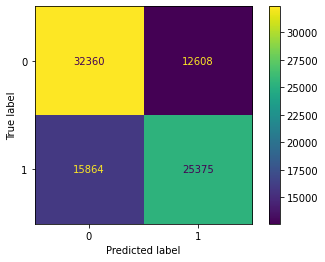

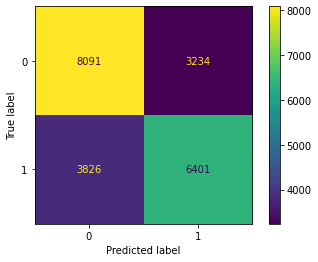

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, r2_score

train_prediction =  searchLog.predict(X_train1)
test_prediction = searchLog.predict(X_test1)

cm_train = confusion_matrix(y_train1, train_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)

disp.plot()

cm_test = confusion_matrix(y_test1, test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)

disp.plot()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Hyperparameters to be optimized
parameters = {'model__n_estimators': [20, 40, 80, 160, 320, 640, 1280], 
              'model__min_samples_split': [8, 10, 12, 24], 
              'model__max_depth': [2, 4, 8]}

model_rf = RandomForestClassifier()
pipeline = Pipeline([('model', model_rf)])
searchRF = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='roc_auc', n_iter=5)

searchRF.fit(X_train1, y_train1)

train_auc = roc_auc_score(y_train1, searchRF.predict_proba(X_train1)[:, 1])
test_auc = roc_auc_score(y_test1, searchRF.predict_proba(X_test1)[:, 1])

print("The training AUC score is {:.3f}".format(train_auc) )
print("The testing AUC score is {:.3f}".format(test_auc) )

The training AUC score is 0.835
The testing AUC score is 0.806


In [ ]:
searchRF.cv_results_

{'mean_fit_time': array([  6.49593854,  22.65763049,  92.65197372,  10.74253063,
        185.47413607]),
 'mean_score_time': array([0.09399481, 0.15624013, 0.82884088, 0.08298502, 1.65266495]),
 'mean_test_score': array([0.68452885, 0.79979709, 0.71919509, 0.79579567, 0.71954749]),
 'param_model__max_depth': masked_array(data=[2, 8, 4, 8, 4],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__min_samples_split': masked_array(data=[24, 12, 12, 24, 12],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__n_estimators': masked_array(data=[80, 80, 640, 40, 1280],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__max_depth': 2,
   'model__min_samples_split': 24,
   'model__n_estimators': 80},
  {'model__max_depth': 8,
   'model__min_samples_split': 12,
   'model__n_estimat

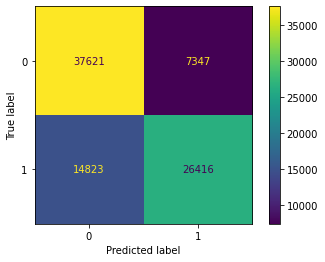

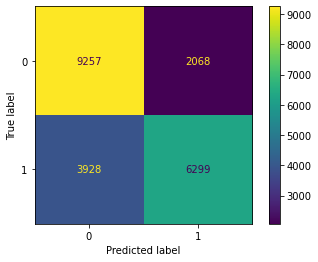

In [ ]:
train_prediction =  searchRF.predict(X_train1)
test_prediction = searchRF.predict(X_test1)

cm_train = confusion_matrix(y_train1, train_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)

disp.plot()

cm_test = confusion_matrix(y_test1, test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)

disp.plot()

# MLP

### Datasets and DataLoaders

In [ ]:
# Generate dataset 
class EssentialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)  # store X as a pytorch Tensor
        self.y = torch.Tensor(y)  # store y as a pytorch Tensor
        self.len = len(self.X)  # number of samples in the data 

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [ ]:
# Define dataset 
train_data = EssentialDataset(X_train, y_train)
val_data = EssentialDataset(X_val, y_val)
test_data = EssentialDataset(X_test, y_test)

# train/test split 
batch_size = 128
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# check that dataloaders are working properly
for loader in [train_dataloader, val_dataloader, test_dataloader]:
    for index, batch in enumerate(loader): 
        # batch returns a X, y stacked in a batch 
        X_batch, y_batch = batch[0], batch[1]
        if index == 0:
            print(X_batch.shape, y_batch.shape)

torch.Size([128, 90]) torch.Size([128])
torch.Size([128, 90]) torch.Size([128])
torch.Size([128, 90]) torch.Size([128])


## Hyperparameter Optimization

In [ ]:
% pip install optuna

     |████████████████████████████████| 308 kB 7.1 MB/s 
     |████████████████████████████████| 81 kB 11.9 MB/s 
     |████████████████████████████████| 210 kB 82.1 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 112 kB 5.0 MB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 146 kB 82.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1110e4204f3c1ecb7dd4c050c01c17e2d50f8648d73de2aca36eff215d137b03
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
from optuna.trial import TrialState
import torch.optim as optim

In [ ]:
DEVICE = 'cuda:0'
BATCHSIZE = 128
CLASSES = 1
EPOCHS = 100
INPUT_NODES = 90

In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 2, 8)
    layers = []

    in_features = INPUT_NODES
    for i in range(n_layers):
        out_features = trial.suggest_categorical("n_nodes{}".format(i), [16,32,64,128,512,1024,2048])
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_p{}".format(i), 0.0, 0.5, step=0.1)
        layers.append(nn.Dropout(p))
        in_features = out_features

    layers.append(nn.Linear(in_features, CLASSES))

    return nn.Sequential(*layers)

In [ ]:
def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    for epoch in range(EPOCHS):
        # Training of the model.
        model.train()
        for (X, y) in train_dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)

        # train your model on each batch here 
        y_pred = model(X)
        y = y.unsqueeze(1)
        loss = torch.nn.BCEWithLogitsLoss()(y_pred, y)
        
        # run backpropagation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
          for batch in val_dataloader:    
              X, y = batch
              X = X.to(DEVICE)
              y = y.to(DEVICE)
              y = y.unsqueeze(1)
              
              # train your model on each batch here 
              y_pred = model(X)
              loss = torch.nn.BCEWithLogitsLoss()(y_pred, y)

              y_pred = torch.sigmoid(y_pred)
              y_pred_tag = torch.round(y_pred)
              correct += y_pred_tag.eq(y.view_as(y_pred_tag)).sum().item()  

        #accuracy = correct / len(val_dataloader.dataset)
        #trial.report(accuracy, epoch)
        auc = roc_auc_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        trial.report(auc, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    #return accuracy
    return auc


Run code below to start hyperparameter tuning

In [ ]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)

    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-05-08 15:49:26,612] A new study created in memory with name: no-name-8eedddc5-79a0-4e1f-a609-10d3bebb66e8
[I 2022-05-08 15:50:23,363] Trial 0 finished with value: 0.7017543859649122 and parameters: {'n_layers': 6, 'n_nodes0': 2048, 'dropout_p0': 0.5, 'n_nodes1': 1024, 'dropout_p1': 0.30000000000000004, 'n_nodes2': 1024, 'dropout_p2': 0.30000000000000004, 'n_nodes3': 512, 'dropout_p3': 0.1, 'n_nodes4': 16, 'dropout_p4': 0.2, 'n_nodes5': 128, 'dropout_p5': 0.1, 'optimizer': 'RMSprop', 'lr': 0.00016889801869925718}. Best is trial 0 with value: 0.7017543859649122.
[I 2022-05-08 15:51:12,392] Trial 1 finished with value: 0.5633484162895928 and parameters: {'n_layers': 2, 'n_nodes0': 1024, 'dropout_p0': 0.4, 'n_nodes1': 128, 'dropout_p1': 0.4, 'optimizer': 'RMSprop', 'lr': 0.00025217455574986006}. Best is trial 0 with value: 0.7017543859649122.
[I 2022-05-08 15:52:03,254] Trial 2 finished with value: 0.592857142857143 and parameters: {'n_layers': 6, 'n_nodes0': 512, 'dropout_p0': 0.4

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  38
  Number of complete trials:  12
Best trial:
  Value:  0.7828054298642534
  Params: 
    n_layers: 2
    n_nodes0: 2048
    dropout_p0: 0.2
    n_nodes1: 512
    dropout_p1: 0.0
    optimizer: RMSprop
    lr: 1.229757871230089e-05


/usr/local/lib/python3.7/dist-packages/optuna/structs.py:18: FutureWarning: `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.
  warnings.warn(_message, FutureWarning)


## Run MLP with best parameters

### Model Architecture

In [ ]:
class EssentialMLP_opt(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = torch.nn.Linear(90, study.best_params['n_nodes0'])
        self.layer2 = torch.nn.Linear(study.best_params['n_nodes0'], study.best_params['n_nodes1'])
        self.layer3 = torch.nn.Linear(study.best_params['n_nodes1'], 1)
        self.relu = torch.nn.ReLU()
        # self.sigmoid = torch.nn.Sigmoid()
        #self.dropout = torch.nn.Dropout(p=params["dropout"])

        self.mlp = torch.nn.Sequential(  self.layer1, self.relu, torch.nn.Dropout(p=study.best_params['dropout_p0']),
                                         self.layer2, self.relu, torch.nn.Dropout(p=study.best_params['dropout_p1']),                         
                                         self.layer3                              
                                         )

    def forward(self, x):
        x = self.mlp(x)
        return x

### Train Model

In [ ]:
def train(model, dataloader, optimizer, device):

    epoch_loss = []
    model.train() # Set model to training mode 
    
    for batch in dataloader:    
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        y = y.unsqueeze(1)
        #print(y)
        #print(y.shape)
        
        # train your model on each batch here 
        y_pred = model(X)
        #print(y_pred)
        #print(y_pred.shape)
        loss = torch.nn.BCEWithLogitsLoss()(y_pred, y)
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(epoch_loss).mean()


def validate(model, dataloader, device):
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y = y.unsqueeze(1)
            
            # validate your model on each batch here 
            y_pred = model(X)

            loss = torch.nn.BCEWithLogitsLoss()(y_pred, y)
            val_loss.append(loss.item())
            
    return np.array(val_loss).mean()

In [ ]:
# device to train on
device = 'cuda:0'

# define model
model_opt = EssentialMLP_opt().to(device)

# define optimizer
optimizer = torch.optim.RMSprop(list(model_opt.parameters()), lr=study.best_params['lr'])

In [ ]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []
last_loss = 100
trigger_times = 0
patience = 20

for epoch in range(100):
    
    # Compute train your model on training data
    epoch_loss = train(model_opt, train_dataloader, optimizer,  device=device)
    
    # Validate your on validation data 
    val_loss = validate(model_opt, val_dataloader, device=device) 

    if val_loss > last_loss:
            trigger_times += 1

            if trigger_times >= patience:
                print('Early stopping!')
                break
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    last_loss = val_loss
    print(epoch, epoch_loss, val_loss)


epoch train loss validation loss
0 0.612271128304593 0.6008761370018737
1 0.5867499710290462 0.5570739646480508
2 0.5749911305966315 0.5697445383627121
3 0.5657343673628646 0.5668618017680025
4 0.5578392101572706 0.555651209942282
5 0.5507395850760596 0.5597094477039494
6 0.5438320565920371 0.5331218810114142
7 0.5376415161343364 0.5370561554007334
8 0.532002908688087 0.53744993675245
9 0.527038387702657 0.5405999532301132
10 0.5216287169750635 0.509249746799469
11 0.5170172998270431 0.5332838839864078
12 0.51277649623233 0.5215536690738103
13 0.5082918037841846 0.5226345139823548
14 0.5039438905654016 0.5296723867115909
15 0.5010816555131565 0.500577932759507
16 0.49565401413998045 0.5126122048456375
17 0.4930741922421889 0.4843995383341018
18 0.48876565841885355 0.5005518336818643
19 0.48672997591557443 0.5125520135441871
20 0.4832288059321317 0.5030415788905261
21 0.4806777200915597 0.4862146402058536
22 0.4768702755887787 0.5126198644507421
23 0.4735760547123946 0.4979548099106305


## Predict on test set

In [ ]:
y_trueList = []
y_predList = []
y_probList = []

with torch.no_grad():    
  for batch in test_dataloader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    y = y.unsqueeze(1).cpu().numpy()
            
    y_pred = model_opt(X)
    y_pred = torch.sigmoid(y_pred)
    y_pred_tag = torch.round(y_pred)
    
    y_trueList.append(y)
    y_predList.append(y_pred_tag.cpu().numpy())
    y_probList.append(y_pred.cpu().numpy())

y_trueList = np.concatenate(y_trueList).ravel()
y_predList = np.concatenate(y_predList).ravel()
y_probList = np.concatenate(y_probList).ravel()

## Output results to CSV

In [ ]:
subset = 'All_NoOrthogroups'
# Save FP, FN, TP, TN genes to file
fp_ind  =  pd.Series([y_trueList[i] == 0 and y_predList[i] == 1 for i in range(len(y_trueList))], name='bools')
fp = data_test[fp_ind.values]

fn_ind  =  pd.Series([y_trueList[i] == 1 and y_predList[i] == 0 for i in range(len(y_trueList))], name='bools')
fn = data_test[fn_ind.values]

tp_ind  =  pd.Series([y_trueList[i] == 1 and y_predList[i] == 1 for i in range(len(y_trueList))], name='bools')
tp = data_test[tp_ind.values]

tn_ind  =  pd.Series([y_trueList[i] == 0 and y_predList[i] == 0 for i in range(len(y_trueList))], name='bools')
tn = data_test[tn_ind.values]

file_fpgenes = "Output/" + subset + "_fpgenes.csv"
fp.to_csv(os.path.join(base_dir, file_fpgenes))

file_fngenes = "Output/" + subset + "_fngenes.csv"
fn.to_csv(os.path.join(base_dir, file_fngenes))

file_tpgenes = "Output/" + subset + "_tpgenes.csv"
tp.to_csv(os.path.join(base_dir, file_tpgenes))

file_tngenes = "Output/" + subset + "_tngenes.csv"
tn.to_csv(os.path.join(base_dir, file_tngenes))

In [ ]:
test_auc = roc_auc_score(y_trueList, y_probList)
print("The testing AUC score is {:.3f}".format(test_auc))

The testing AUC score is 0.820


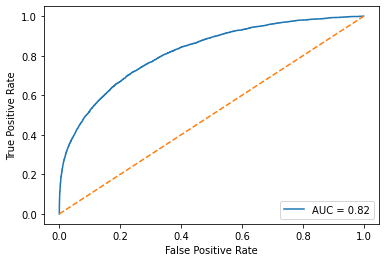

In [ ]:
# Plot AUC-ROC curve
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_trueList, y_probList)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.plot([0, 1], [0, 1], '--')
plt.show()

In [ ]:
# Save FPR, TPR and classification report
file_fpr = "Output/" + subset + "_fpr.csv"
np.savetxt(os.path.join(base_dir, file_fpr), fpr, delimiter=",")

file_tpr = "Output/" + subset + "_tpr.csv"
np.savetxt(os.path.join(base_dir, file_tpr), tpr, delimiter=",")

#file_rocauc = "Output/" + subset + "_rocauc.csv"
#np.savetxt(os.path.join(base_dir, file_rocauc), roc_auc, delimiter=",")

In [ ]:
report = metrics.classification_report(y_trueList, y_predList, output_dict=True)
report_df = pd.DataFrame(report).transpose()

In [ ]:
file_report = "Output/" + subset + "_report.csv"
report_df.to_csv(os.path.join(base_dir, file_report))